In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import torch
from torch import nn
mse = nn.MSELoss()


np.random.seed(42)

In [2]:
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)
ADF_result = adfuller(ARMA_1_1)
ADF_result

(-6.429878682042645,
 1.7078466680101036e-08,
 20,
 979,
 {'1%': -3.4370471695043037,
  '5%': -2.8644967585264784,
  '10%': -2.5683443301882956},
 2760.1171729466205)

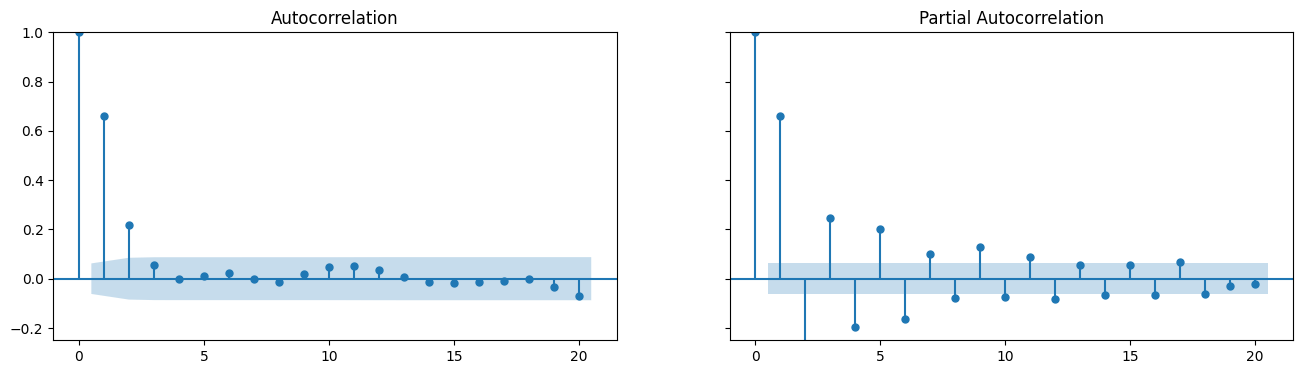

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(16,4) )
plot_acf(ARMA_1_1, lags=20, ax=ax1)
plot_pacf(ARMA_1_1, lags=20, ax=ax2)
plt.ylim(-0.25, 1)
plt.show()

In [36]:
from typing import Union
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')


def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [37]:
from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [38]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2805.930279
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


In [46]:


model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)

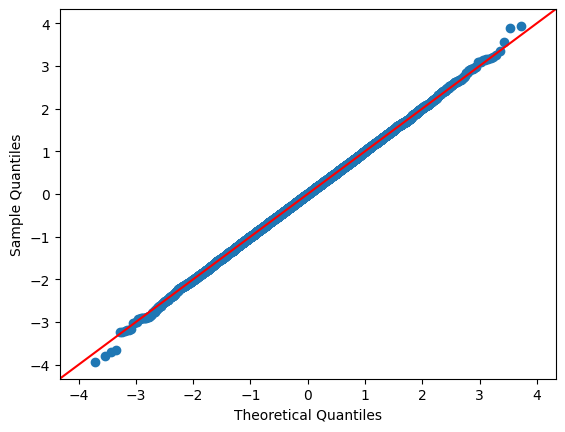

In [221]:
from statsmodels.graphics.gofplots import qqplot

qqplot(model_fit.resid, line='45');

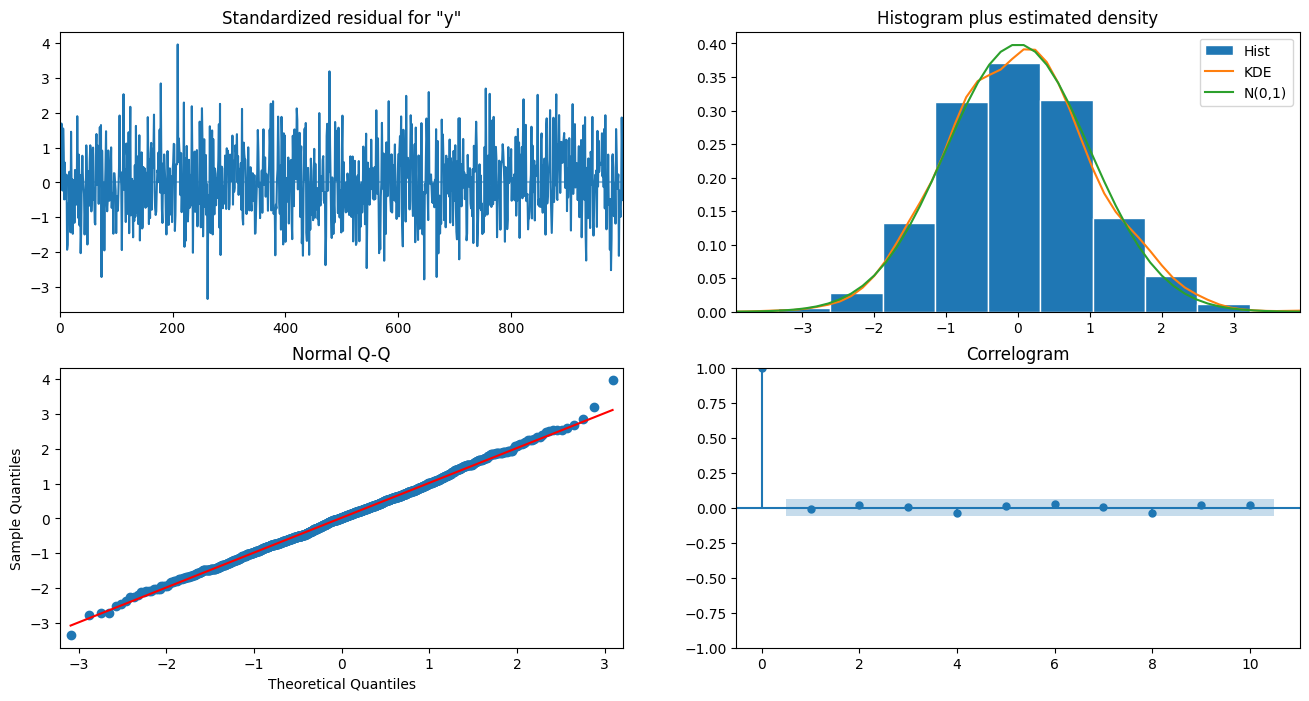

In [53]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [52]:
from statsmodels.stats.diagnostic import acorr_ljungbox
tr = acorr_ljungbox(model_fit.resid, np.arange(1, 11, 1))
print(tr)

     lb_stat  lb_pvalue
1   0.030706   0.860897
2   0.528021   0.767966
3   0.540904   0.909817
4   2.079774   0.721089
5   2.271897   0.810385
6   2.896262   0.821750
7   2.900378   0.894063
8   4.418799   0.817501
9   4.787567   0.852419
10  5.246805   0.874093


In [278]:
df = pd.read_csv('./data/bandwidth.csv')
df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


In [279]:
df.shape

(10000, 1)

In [280]:
#df.index = pd.date_range('2019-01-01', periods = 10000, freq='1h')
df

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816
...,...
9995,740.546059
9996,738.906228
9997,736.057995
9998,733.559640


Text(0, 0.5, 'Hourly bandwith usage (MBps)')

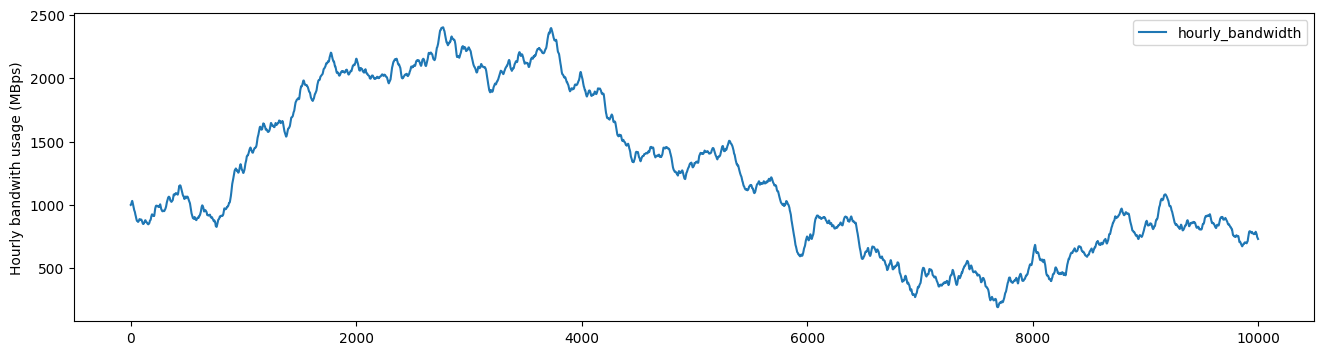

In [281]:
ax = df.plot( figsize=(16,4),  layout='constrained')
ax.set_ylabel('Hourly bandwith usage (MBps)')

In [282]:
ADF_result = adfuller(df['hourly_bandwidth'])
ADF_result

(-0.8714653199453133,
 0.7972240255014424,
 6,
 9993,
 {'1%': -3.431004556246501,
  '5%': -2.8618292749021865,
  '10%': -2.5669239758928017},
 28347.577478302363)

In [284]:
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)

<Axes: >

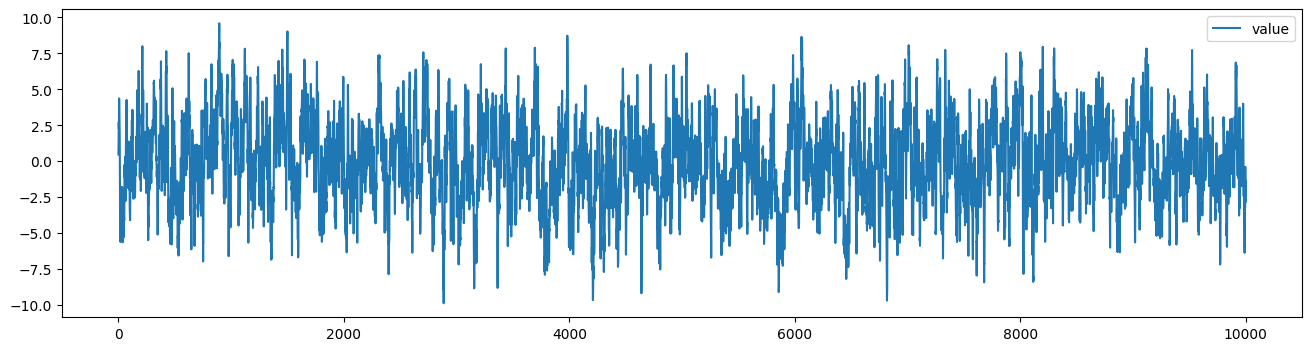

In [285]:
df_diff = pd.DataFrame({'value': bandwidth_diff})
df_diff.index = df_diff.index + 1
#df_diff.index = pd.date_range('2019-01-01 01:00:00', periods = 9999, freq='1h')
df_diff.plot( figsize=(16,4),  layout='constrained')

In [286]:
ADF_result = adfuller(bandwidth_diff)
ADF_result

(-20.69485386378899,
 0.0,
 5,
 9993,
 {'1%': -3.431004556246501,
  '5%': -2.8618292749021865,
  '10%': -2.5669239758928017},
 28344.57207305265)

In [287]:
train = df_diff[:-168]
test = df_diff[-168:]
print(f'train:{len(train)}, test:{len(test)}')

train:9831, test:168


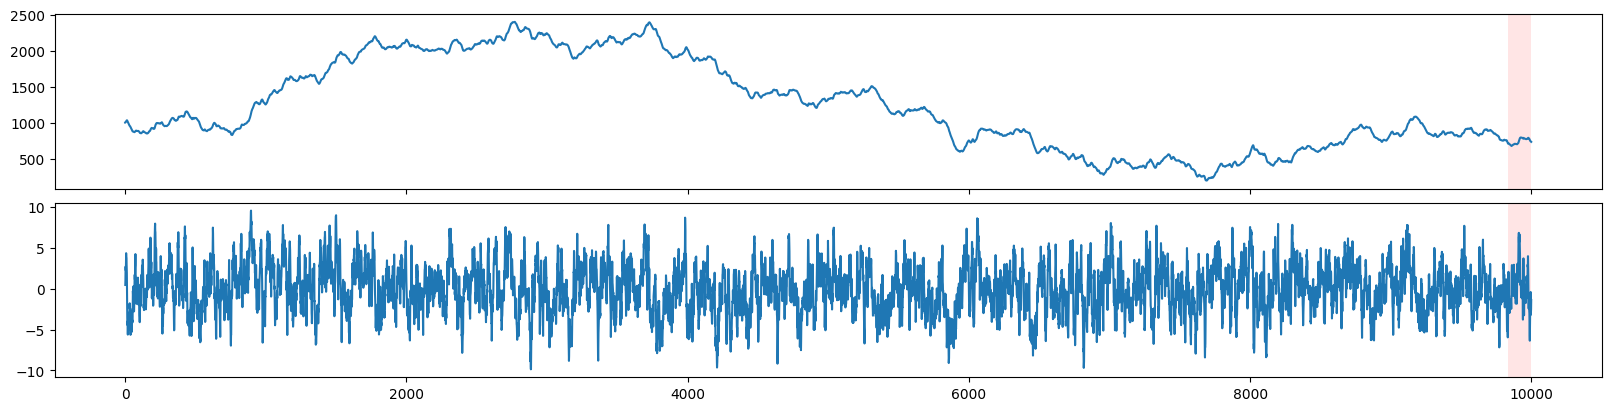

In [288]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,4),  layout='constrained')
ax1.plot(df )
ax1.axvspan(9831, 10000, facecolor='red', alpha=0.1)
ax2.plot(df_diff)
ax2.axvspan(9831, 10000, facecolor='red', alpha=0.1)
plt.show()

In [289]:
def optimize_ARMA_Order(endog: Union[pd.Series, list], order_list: list) -> tuple:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    pq = result_df.head(1)['(p,q)'].item()
    
    return (pq[0], 0, pq[1] )

In [290]:
order = optimize_ARMA_Order(train['value'], order_list)

  0%|          | 0/16 [00:00<?, ?it/s]

In [291]:
model = SARIMAX(train['value'], order=order, simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 9831
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -13989.532
Date:                Mon, 12 Aug 2024   AIC                          27991.064
Time:                        15:05:29   BIC                          28034.224
Sample:                             0   HQIC                         28005.686
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3532      0.053      6.668      0.000       0.249       0.457
ar.L2          0.4150      0.066      6.250      0.000       0.285       0.545
ar.L3          0.0546      0.036      1.530      0.1

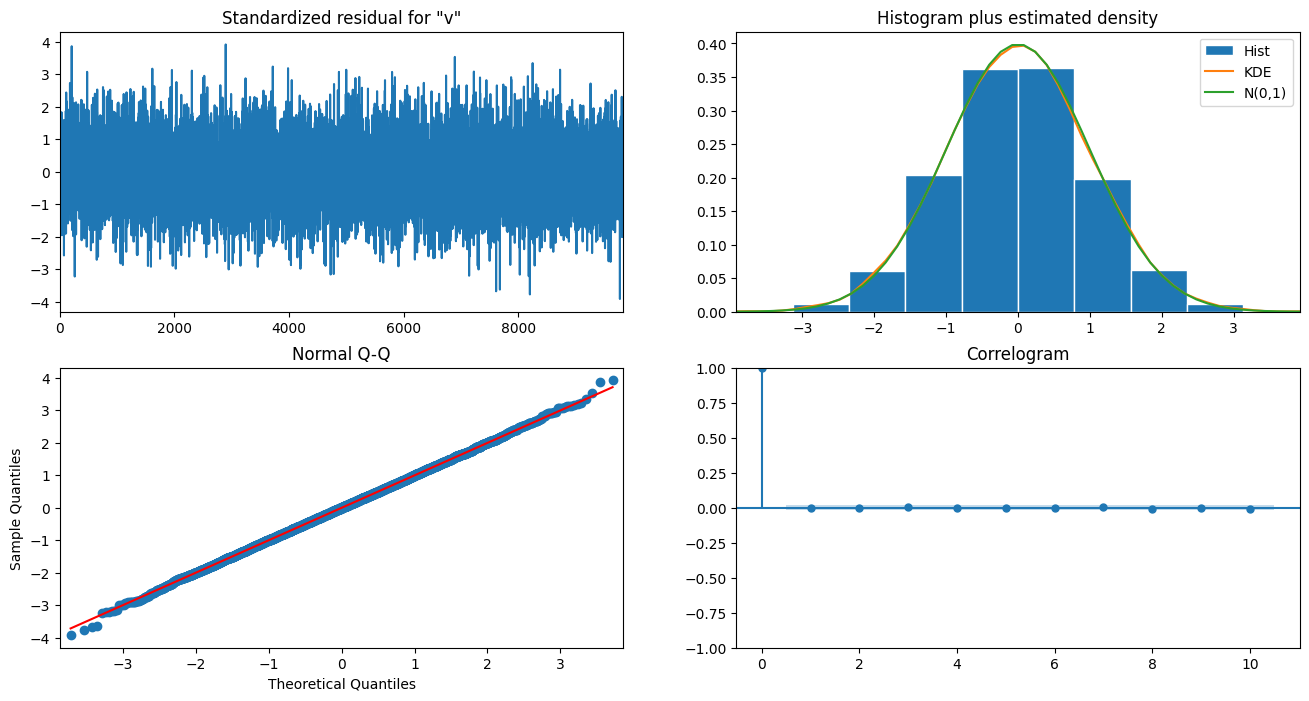

In [292]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [293]:
tr = acorr_ljungbox(model_fit.resid, np.arange(1, 11, 1))
print(tr.lb_pvalue)

1     0.978461
2     0.992353
3     0.997508
4     0.999201
5     0.997428
6     0.999154
7     0.999614
8     0.994917
9     0.997995
10    0.997236
Name: lb_pvalue, dtype: float64


In [294]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str, order = (0,0,0)) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=order)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [295]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA', order)

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_ARMA'] = pred_ARMA

test.head(5)

,value,pred_mean,pred_last_value,pred_ARMA
9832,-5.943995,-0.028214,-5.791207,-5.453470
9833,-5.865194,-0.028816,-5.943995,-5.477567
9834,-3.197066,-0.029410,-5.865194,-5.347632
9835,-1.090197,-0.029732,-3.197066,-2.164184
9836,0.665291,-0.029840,-1.090197,-0.407950


<Axes: >

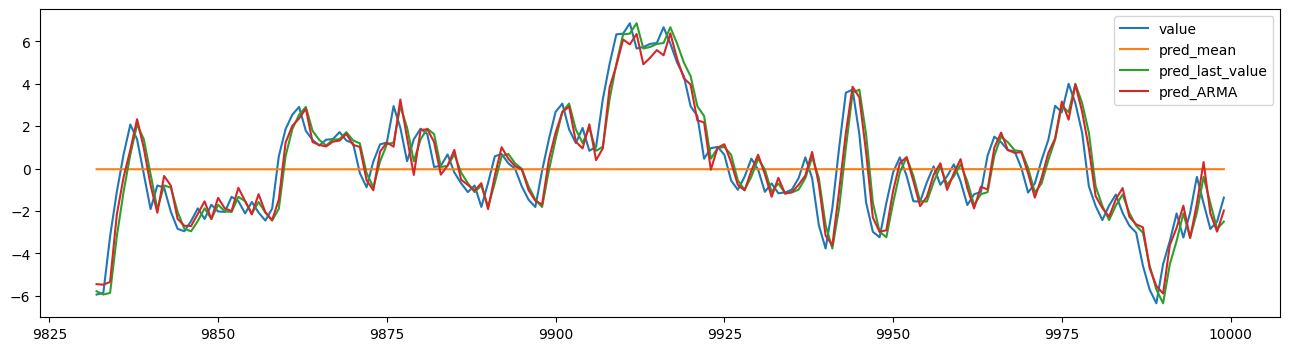

In [296]:
test.plot(figsize=(16,4), layout='constrained')

<Axes: >

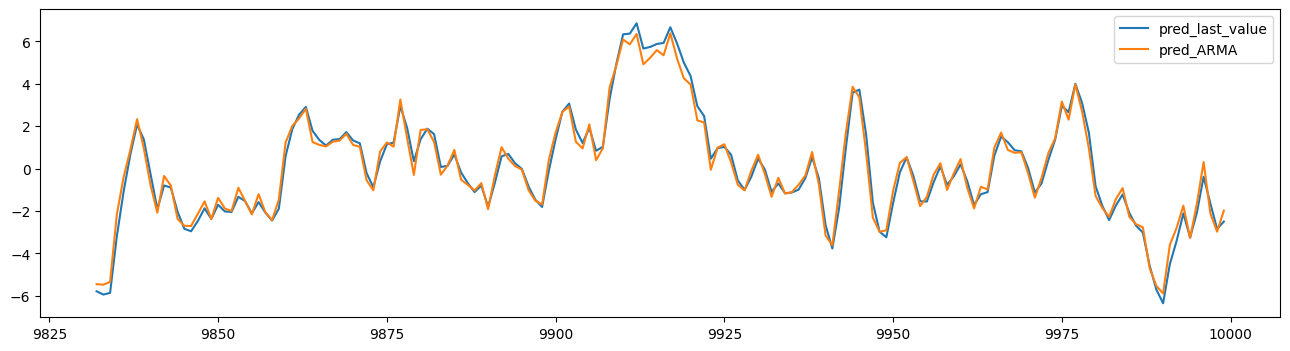

In [297]:
test[['pred_last_value','pred_ARMA']].plot(figsize=(16,4), layout='constrained')

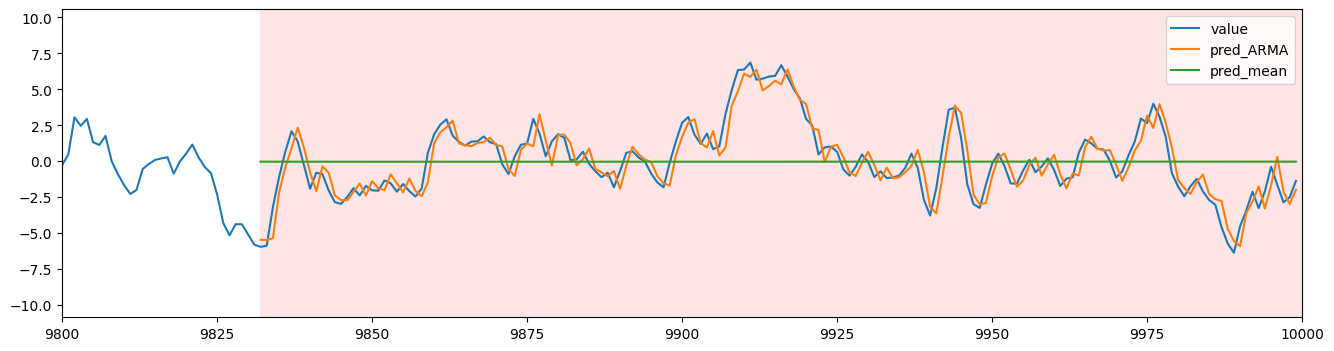

In [298]:
ax = df_diff.plot( figsize=(16,4),  layout='constrained' )
test[['pred_ARMA', 'pred_mean']].plot( ax = ax)
ax.set_xlim(9800, 10000)
ax.axvspan(9832, 10000, facecolor='red', alpha=0.1)
plt.show()

In [299]:
loss = {}
loss['mean'] =  mse( torch.FloatTensor( test['pred_mean'][:].values),  torch.FloatTensor(test['value'][:].values) ).item()
loss['last_value'] = mse( torch.FloatTensor( test['pred_last_value'][:].values),  torch.FloatTensor(test['value'][:].values) ).item()
loss['arma'] =  mse( torch.FloatTensor( test['pred_ARMA'][:].values),  torch.FloatTensor(test['value'][:].values) ).item()
loss

{'mean': 6.305950164794922,
 'last_value': 1.1794626712799072,
 'arma': 0.9009236097335815}

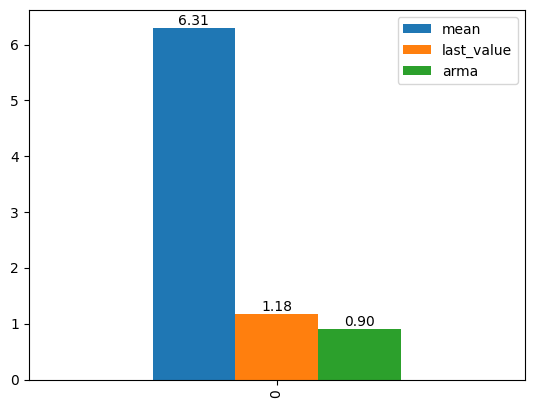

In [300]:
ax =  pd.DataFrame([loss]).plot.bar()
for index, label in enumerate(loss):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)

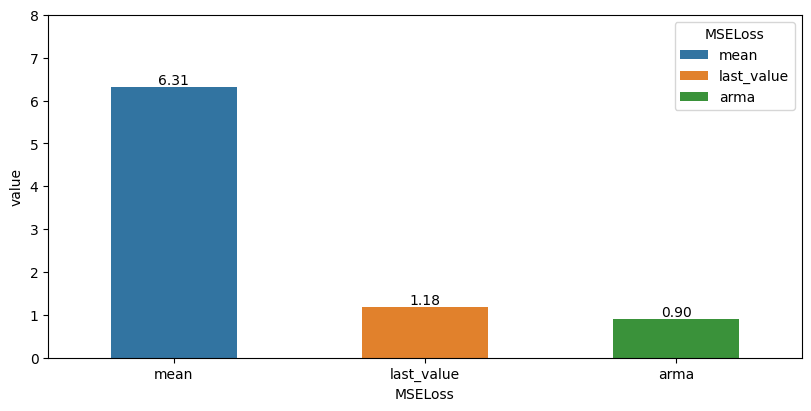

In [301]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([loss]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )
ax.set_ylim(0, 8)
ax.set_xlabel('MSELoss')
ax.legend(title='MSELoss')
for index, label in enumerate(loss):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)

In [302]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()

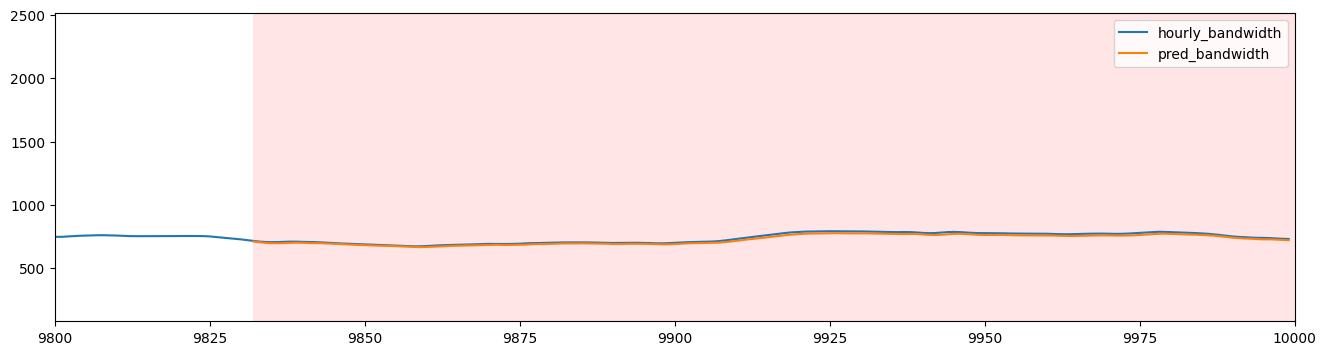

In [303]:
ax = df[:].plot(figsize=(16,4),  layout='constrained')
ax.axvspan(9832, 10000, facecolor='red', alpha=0.1)
ax.set_xlim(9800, 10000)
plt.show()

In [304]:
df = df.astype('float64')

mae = nn.L1Loss()
loss = mae(
    torch.FloatTensor( df['pred_bandwidth'][9832:].values),  
    torch.FloatTensor(df['hourly_bandwidth'][9832:].values) 
).item()
loss

11.256330490112305